For this script, we used the wider set of EF measures. so we could use feature selection etc. 
This was in "MB_EF_Detail_Reduced_Dec21" at first. Let's use this again.

In [1]:
import numpy as np
from numpy import absolute, mean, std
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

import random

random.seed(10)

# https://machinelearningmastery.com/rfe-feature-selection-in-python/


In [2]:
#work_p = "C:/Users/claire.smid/Documents/Main_STUDY/Model-based_learning_mainstudy/"

work_p = "C:/Users/claire.smid/Documents/DCP/Writing/Thesis/Chapter2/"

# Including all decision making, EFs and mental health:
#dataset = pd.read_csv(work_p+"All_DMs_EFs_MHs_Nov21.csv", sep=',') 

# Including all decision making and EFs
#dataset = pd.read_csv(work_p+"All_DMs_EFs_Nov21.csv", sep=',') 

# Including EFs and MB only
#dataset = pd.read_csv(work_p+"MB_EFs_Only_Nov21.csv", sep=',') 
#dataset = pd.read_csv(work_p+"MB_EF_Detail_Imputed_Dec21.csv", sep=',') 
#dataset = pd.read_csv(work_p+"MB_EF_Detail_Imputed_REDUCED_Dec21.csv", sep=',') 
#dataset = pd.read_csv(work_p+"MBMF_EF_Detail_Imp_6Jun2022.csv", sep=',')
dataset = pd.read_csv(work_p+"MBMF_EF_Detail_Imp_9Jun2022.csv", sep=',') 

pd.options.display.max_columns = 100

dataset

,ID,Session,School,Gender,Age_Frac_Imp,SES_inv_z,Avg_Pts,Avg_Pts_lo,Avg_Pts_hi,w_P6,w_diff,it_P6,lr_P6,eg_P6,st_P6,repst_P6,it,lr,eg,st,repst,T_Vocab,T_Matrix,Corsi_WM_Span,CogFlex_t,SSRT,FlankerSwitch_t,FlankerInhib_t,Stroop_t,AY_RCS,BX_RCS,Nback_1_RCS,Nback_2_RCS,CF_Mix_RCS_Diff,SSRT_SSD_z
0,1,0,Trevor Roberts School,M,12.444444,0.226732,0.013173,-0.002222,0.029551,0.425788,0.121567,0.619787,0.437227,0.419932,-0.177439,-0.709067,0.625122,0.442486,0.420558,-0.177359,-0.704026,62,66,7,0.524022,-0.798678,0.035289,-0.303618,-0.818045,1.785449,0.927080,0.241960,0.114083,-0.699165,0.316186
1,4,0,Trevor Roberts School,F,11.838889,-0.587075,0.024752,0.004831,0.041414,0.528114,-0.142475,0.804932,0.698279,0.486952,-0.435025,-0.862134,0.812849,0.685928,0.486859,-0.426516,-0.851632,55,50,5,1.152471,0.028908,0.242714,0.563637,-0.013837,0.985358,1.401536,0.272975,0.123974,-0.018518,-0.640517
2,5,0,Trevor Roberts School,M,7.611111,1.040539,0.043889,0.037037,0.052972,0.770192,0.132597,0.880334,0.755154,0.530449,-0.589862,-0.083494,0.846292,0.747178,0.556262,-0.601976,-0.080824,66,55,4,-1.093324,-0.380691,0.525759,-0.140001,-0.205424,0.990982,0.373066,0.117747,0.174845,-0.171262,0.880708
3,8,0,Trevor Roberts School,M,6.747222,0.226732,0.013740,-0.022676,0.054293,0.582383,0.028154,0.651551,0.764537,0.577141,0.588800,0.396509,0.652178,0.783163,0.582775,0.589636,0.395179,64,61,4,0.458539,-1.489266,-0.041334,-0.248403,1.083356,0.562811,0.437377,0.102242,0.228547,-0.138648,-0.071924
4,15,0,Trevor Roberts School,M,10.600000,0.226732,-0.014891,0.016414,-0.040881,0.448529,-0.036160,0.553742,0.489282,0.530107,-0.303803,-1.629661,0.553467,0.487266,0.528799,-0.305209,-1.630474,55,62,6,-0.133400,0.016327,-0.679340,-0.246747,0.085989,0.461337,0.558434,0.216780,0.260057,0.025455,-1.590435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,193,0,Broadfields,M,10.486111,-2.214688,0.098073,0.071605,0.120545,0.422117,0.117357,0.433004,0.519166,0.491737,0.173996,-0.269121,0.436899,0.517092,0.471755,0.175653,-0.262585,41,56,6,0.329597,0.200856,-0.572747,0.212403,0.187235,1.589251,2.482398,0.174274,0.156276,0.034773,1.374665
65,195,0,Merton Court,M,10.372222,-0.587075,-0.017052,-0.065302,0.045455,0.610913,-0.218845,0.445750,0.349609,0.394229,-0.074491,-0.851411,0.453946,0.367773,0.398445,-0.070527,-0.840291,58,64,6,0.680336,-0.707812,-0.136637,0.689489,-0.980713,0.913796,1.094341,0.217520,0.150937,-0.266687,-1.236251
66,196,0,Orley Farm,M,8.608333,0.498001,0.057756,0.049645,0.064815,0.718295,0.107204,1.381509,0.868366,0.658000,0.382585,-0.281852,1.387507,0.884099,0.678044,0.386831,-0.277990,64,52,5,-0.330512,0.909617,0.208257,-0.148340,-0.622866,1.036768,0.302673,0.209424,0.273568,-0.564426,0.139772
67,202,0,Newland House,F,11.236111,1.040539,0.044004,0.045351,0.042735,0.893768,0.043038,1.296684,0.839617,0.514458,0.758670,-0.065990,1.165809,0.808938,0.521772,0.873589,-0.060433,63,54,7,0.458539,-0.562425,-0.814565,0.551108,-0.565334,0.818956,0.818888,0.140716,0.135013,0.012360,-1.571437


In [3]:
# one hot encoding
dataset.Gender.replace(to_replace=['M','F'],value=[1,0],inplace=True)

In [5]:
# # 6 jun dataset
# X = dataset.iloc[:, np.r_[14:34]]
# X_cols = X
# y = dataset.iloc[:,8]

# 7 jun dataset
X = dataset.iloc[:, np.r_[21:35]]
X_cols = X
y = dataset.iloc[:,9]

In [6]:
X

,T_Vocab,T_Matrix,Corsi_WM_Span,CogFlex_t,SSRT,FlankerSwitch_t,FlankerInhib_t,Stroop_t,AY_RCS,BX_RCS,Nback_1_RCS,Nback_2_RCS,CF_Mix_RCS_Diff,SSRT_SSD_z
0,62,66,7,0.524022,-0.798678,0.035289,-0.303618,-0.818045,1.785449,0.927080,0.241960,0.114083,-0.699165,0.316186
1,55,50,5,1.152471,0.028908,0.242714,0.563637,-0.013837,0.985358,1.401536,0.272975,0.123974,-0.018518,-0.640517
2,66,55,4,-1.093324,-0.380691,0.525759,-0.140001,-0.205424,0.990982,0.373066,0.117747,0.174845,-0.171262,0.880708
3,64,61,4,0.458539,-1.489266,-0.041334,-0.248403,1.083356,0.562811,0.437377,0.102242,0.228547,-0.138648,-0.071924
4,55,62,6,-0.133400,0.016327,-0.679340,-0.246747,0.085989,0.461337,0.558434,0.216780,0.260057,0.025455,-1.590435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,41,56,6,0.329597,0.200856,-0.572747,0.212403,0.187235,1.589251,2.482398,0.174274,0.156276,0.034773,1.374665
65,58,64,6,0.680336,-0.707812,-0.136637,0.689489,-0.980713,0.913796,1.094341,0.217520,0.150937,-0.266687,-1.236251
66,64,52,5,-0.330512,0.909617,0.208257,-0.148340,-0.622866,1.036768,0.302673,0.209424,0.273568,-0.564426,0.139772
67,63,54,7,0.458539,-0.562425,-0.814565,0.551108,-0.565334,0.818956,0.818888,0.140716,0.135013,0.012360,-1.571437


In [7]:
y

0     0.425788
1     0.528114
2     0.770192
3     0.582383
4     0.448529
        ...   
64    0.422117
65    0.610913
66    0.718295
67    0.893768
68    0.630908
Name: w_P6, Length: 69, dtype: float64

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

## LOOCV with all features

In [9]:
#sorted(sklearn.metrics.SCORERS.keys())

In [10]:
# find number of sam`aples
n = X.shape[0]
# create loocv procedure
cv = LeaveOneOut()
# create model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
# evaluate model
scores = cross_val_score(regressor, X, y, scoring='neg_mean_squared_error', cv=n)
# force positive
#scores = absolute(scores)

# report performance
print('MSE: %.3f (%.3f)' % (mean(scores), std(scores)))


MSE: -0.036 (0.044)


# FIRST RFE

In [11]:
# explore the algorithm wrapped by RFE
# automatically select the number of features for RFE
from sklearn.linear_model import LinearRegression

# create pipeline
rfe = RFECV(estimator=LinearRegression(),min_features_to_select=1)
model = LinearRegression()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# find number of samples
n = X.shape[0]
# create loocv procedure
cv = LeaveOneOut()
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='neg_mean_squared_error', cv=n, n_jobs = -1)

# report performance
print('MSE: %.3f (%.3f)' % (mean(scores), std(scores)))


MSE: -0.031 (0.038)


# Printing the best predicting features

In [12]:
# find out which predictors
rfe.fit(X,y)
data_top = X_cols.columns
# summarise all features
for i in range(X.shape[1]):
    print('Selected %s,\t Rank: %.1f, \tName: %s' % (rfe.support_[i], rfe.ranking_[i],data_top[i]))

Selected False,	 Rank: 5.0, 	Name: T_Vocab
Selected False,	 Rank: 6.0, 	Name: T_Matrix
Selected True,	 Rank: 1.0, 	Name: Corsi_WM_Span
Selected True,	 Rank: 1.0, 	Name: CogFlex_t
Selected False,	 Rank: 11.0, 	Name: SSRT
Selected False,	 Rank: 9.0, 	Name: FlankerSwitch_t
Selected False,	 Rank: 7.0, 	Name: FlankerInhib_t
Selected False,	 Rank: 3.0, 	Name: Stroop_t
Selected False,	 Rank: 10.0, 	Name: AY_RCS
Selected False,	 Rank: 8.0, 	Name: BX_RCS
Selected False,	 Rank: 4.0, 	Name: Nback_1_RCS
Selected False,	 Rank: 13.0, 	Name: Nback_2_RCS
Selected False,	 Rank: 2.0, 	Name: CF_Mix_RCS_Diff
Selected False,	 Rank: 12.0, 	Name: SSRT_SSD_z


## Use permutation importance to find best predicting features

In [13]:
from sklearn.model_selection import RepeatedKFold
import eli5
from eli5.sklearn import PermutationImportance
from eli5 import show_prediction, show_weights

Xfeature_names = X_cols.columns

# create pipeline
regressor = LinearRegression()

cv = RepeatedKFold(n_splits=6, n_repeats=100, random_state=1)
perm = PermutationImportance(regressor, cv = cv)
perm.fit(X,y)

show_weights(perm, feature_names = X_cols.columns.tolist())
#show_prediction(perm, X.iloc[4], feature_names = X.columns.tolist())

C:\Users\claire.smid\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classifier=False as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Weight,Feature
0.1964 ± 0.7435,CogFlex_t
0.0736 ± 0.5376,Nback_1_RCS
0.0718 ± 0.5901,Corsi_WM_Span
0.0359 ± 0.4710,CF_Mix_RCS_Diff
0.0232 ± 0.3209,T_Vocab
0.0109 ± 0.3522,Stroop_t
0.0053 ± 0.3363,T_Matrix
-0.0048 ± 0.3314,FlankerInhib_t
-0.0122 ± 0.2202,SSRT
-0.0147 ± 0.3437,AY_RCS


[ 0.02319304  0.00533905  0.07178353  0.19640075 -0.01224947 -0.02114532
 -0.00481863  0.01094437 -0.0146837  -0.01930428  0.07359197 -0.03571911
  0.03590126 -0.02653247]
Feature: 0, Score: 0.19640
Feature: 1, Score: 0.07359
Feature: 2, Score: 0.07178
Feature: 3, Score: 0.03590
Feature: 4, Score: 0.02319
Feature: 5, Score: 0.01094
Feature: 6, Score: 0.00534
Feature: 7, Score: -0.00482
Feature: 8, Score: -0.01225
Feature: 9, Score: -0.01468
Feature: 10, Score: -0.01930
Feature: 11, Score: -0.02115
Feature: 12, Score: -0.02653
Feature: 13, Score: -0.03572


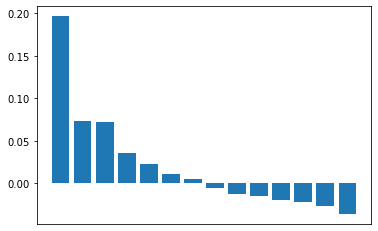

In [17]:
importance = perm.feature_importances_
names = X_cols.columns.tolist()
#print(importance)
print(importance)
f_sorted = sorted(importance, reverse = True)

# summarize feature importance
for i,v in enumerate(f_sorted):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.bar([x for x in range(len(f_sorted))], f_sorted)
plt.tick_params(axis='x',bottom=False,labelbottom=False)
plt.show()

## Hyper parameter tuning

In [18]:
regressor.get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize', 'positive'])

In [19]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# find number of samples
X = dataset[["CogFlex_t"]]
#X = dataset[["FlankerInhib_t","OneBack_WM_t"]]
n = X.shape[0]
# create loocv procedure
cv = LeaveOneOut()
# create model
regressor = LinearRegression()
# define search space
space = dict()
#space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
#space['alpha'] =  [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]
space['positive'] = [True, False]
# define search
search = GridSearchCV(regressor,space,scoring='neg_mean_squared_error',cv=cv, n_jobs = -1)
# execute search
result = search.fit(X,y)

# summarize result
print('Best MSE Score: %s' % result.best_score_)
print('Best Hyperparameters %s' % result.best_params_ )



Best MSE Score: -0.02714134481935387
Best Hyperparameters {'fit_intercept': True, 'normalize': True, 'positive': False}


## Kfold cross validation with RFE

This seems a little less accurate than the LOOCV approach

In [20]:
# explore the algorithm wrapped by RFE
# automatically select the number of features for RFE


# create pipeline
regressor = LinearRegression(fit_intercept=True,normalize=True,positive=False)
# evaluate model
cv = RepeatedKFold(n_splits=6, n_repeats=100, random_state=1)
n_scores = cross_val_score(regressor, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
r2_scores = cross_val_score(regressor, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
explained_var = cross_val_score(regressor, X, y, scoring='explained_variance', cv=cv, n_jobs=-1, error_score='raise')


# report performance
print('MSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print('r2: %.3f (%.3f)' % (mean(r2_scores), std(r2_scores)))
print('exp var: %.3f' % mean(explained_var))


MSE: -0.027 (0.011)
r2: -0.087 (0.292)
exp var: 0.049


## new results:
### axcpt, cf
- MSE: -0.030
- r2: -0.196
- exp var: -0.045


## permutation testing

In [20]:
#conda install -c conda-forge eli5

In [21]:
from sklearn.model_selection import RepeatedKFold
import eli5
from eli5.sklearn import PermutationImportance
from eli5 import show_prediction, show_weights

Xfeature_names = X.columns

# create pipeline
regressor = LinearRegression(fit_intercept=True,normalize=True)

cv = RepeatedKFold(n_splits=6, n_repeats=3, random_state=1)
perm = PermutationImportance(regressor, cv = cv)
perm.fit(X,y)

show_weights(perm, feature_names = X.columns.tolist())
#show_prediction(perm, show_feature_values=True)

C:\Users\claire.smid\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classifier=False as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Weight,Feature
0.0633 ± 0.4032,FlankerInhib_t
-0.0400 ± 0.1494,OneBack_WM_t


## Repeat with PCA
- first just run it with all

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.85)

# from column 8 onwards no more model parameters, or maybe just include all?
# now including only the EFs for the first approach, and splitting factors for the later approach
X = dataset.iloc[:, np.r_[53:64]]
y = dataset.iloc[:,38]

pca.fit(X)
pc_X = pca.transform(X)

# find number of sam`aples
n = pc_X.shape[0]
# create loocv procedure
cv = LeaveOneOut()
# create model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
# evaluate model
scores = cross_val_score(regressor, pc_X, y, scoring='neg_mean_squared_error', cv=n)
# force positive
#scores = absolute(scores)

# report performance
print('MSE: %.3f (%.3f)' % (mean(scores), std(scores)))

MSE: -0.020 (0.035)


In [24]:
principalDF = pd.DataFrame(data = pc_X)
principalDF

,0,1
0,-10.806093,5.635652
1,5.193670,-1.406802
2,-6.282225,-5.165849
3,-19.173499,-8.897218
4,-2.937059,7.417833
...,...,...
64,21.735025,-11.997933
65,-6.506532,6.879172
66,-2.783277,-6.026423
67,-3.415686,-3.863318


## then run rfe again

In [25]:
# explore the algorithm wrapped by RFE
# automatically select the number of features for RFE
from sklearn.linear_model import LinearRegression

# create pipeline
rfe = RFECV(estimator=LinearRegression(),min_features_to_select=1)
model = LinearRegression()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# find number of samples
n = pc_X.shape[0]
# create loocv procedure
cv = LeaveOneOut()
# evaluate model
scores = cross_val_score(pipeline, pc_X, y, scoring='neg_mean_squared_error', cv=n, n_jobs = -1)

# report performance
print('MSE: %.3f (%.3f)' % (mean(scores), std(scores)))


MSE: -0.020 (0.035)


In [26]:
# find out which predictors
rfe.fit(pc_X,y)
#data_top=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']
data_top=['PC1','PC2']
# data_top = ['MemSpeed_negBXRCS','posBXRCS_MemSpeed','PBI_InConIES',
#                                                    'negSwitchIES_negPBI','DP2_negCFSwitchIES',
#                                                    'negCFSwitchIES_InconIES','negInConIES_AYRCS']
# summarise all features
for i in range(pc_X.shape[1]):
    print('row: %d, Selected %s,\t Rank: %.1f, \tName: %s' % (i, rfe.support_[i], rfe.ranking_[i],data_top[i]))

row: 0, Selected False,	 Rank: 2.0, 	Name: PC1
row: 1, Selected True,	 Rank: 1.0, 	Name: PC2


## Permutation testing for factors

In [27]:
from sklearn.model_selection import RepeatedKFold
import eli5
from eli5.sklearn import PermutationImportance
from eli5 import show_prediction, show_weights

# pca = PCA(n_components = 0.90)

# # from column 8 onwards no more model parameters, or maybe just include all?
# # now including only the EFs for the first approach, and splitting factors for the later approach
# X = dataset.iloc[:,12:]
# y = dataset.iloc[:,2]

#pca.fit(X)
#pc_X = pca.transform(X)

Xfeature_names = data_top

# create pipeline
regressor = LinearRegression()

cv = RepeatedKFold(n_splits=6, n_repeats=3, random_state=1)
perm = PermutationImportance(regressor, cv = cv)
perm.fit(pc_X,y)

show_weights(perm, feature_names = Xfeature_names)
#show_prediction(perm, X.iloc[4], feature_names = X.columns.tolist())

C:\Users\claire.smid\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classifier=False as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Weight,Feature
0.0340 ± 0.4262,PC2
-0.0255 ± 0.1127,PC1


## Hyper parameter tuning

In [28]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

var = pc_X[:,1:2]
X = var.reshape(len(var),1)

# find number of samples
n = X.shape[0]
# create loocv procedure
cv = LeaveOneOut()
# create model
regressor = LinearRegression()
# define search space
space = dict()
#space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
#space['alpha'] =  [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]
# define search
search = GridSearchCV(regressor,space,scoring='neg_mean_squared_error',cv=cv, n_jobs = -1)
# execute search
result = search.fit(X,y)

# summarize result
print('Best MSE Score: %s' % result.best_score_)
print('Best Hyperparameters %s' % result.best_params_ )



Best MSE Score: -0.020048751717277064
Best Hyperparameters {'fit_intercept': True, 'normalize': True}


In [29]:
# explore the algorithm wrapped by RFE
# automatically select the number of features for RFE
from sklearn.model_selection import RepeatedKFold

# make the model manually with the predictors
# for metacontrol
#X = pc_X[:,[1,4,6]]
# for w
#X = pc_X[:,[2,4]]
# for lr
#X = pc_X[:,[5]]

# create pipeline
regressor = LinearRegression(fit_intercept=False,normalize=True)
# evaluate model
cv = RepeatedKFold(n_splits=6, n_repeats=3, random_state=1)
n_scores = cross_val_score(regressor, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
r2_scores = cross_val_score(regressor, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
explained_var = cross_val_score(regressor, X, y, scoring='explained_variance', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('MSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print('r2: %.3f (%.3f)' % (mean(r2_scores), std(r2_scores)))
print('exp var: %.3f' % mean(explained_var))

MSE: -0.308 (0.049)
r2: -21.964 (20.063)
exp var: -0.042


## Old method of k-fold CV

In [ ]:
# # explore the algorithm wrapped by RFE
# # automatically select the number of features for RFE
# from sklearn.model_selection import RepeatedKFold

# # create pipeline
# rfe = RFECV(estimator=LinearRegression())
# model = LinearRegression()
# pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# # evaluate model
# cv = RepeatedKFold(n_splits=4, n_repeats=3, random_state=1)
# n_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
# r2_scores = cross_val_score(pipeline, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')


# # report performance
# print('MSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# print('r2: %.3f (%.3f)' % (mean(r2_scores), std(r2_scores)))


In [ ]:
# # find out which predictors
# rfe.fit(X,y)
# data_top = X.columns
# # summarise all features
# for i in range(X.shape[1]):
#     print('Selected %s,\t Rank: %.1f, \tName: %s' % (rfe.support_[i], rfe.ranking_[i],data_top[i]))

In [ ]:
# # print only the included variables
# for i, col in enumerate(data_top):
#     #print(i,col)
#     if rfe.support_[i]:
#         print(data_top[i])
#         print(rfe.ranking_[i])